In [75]:
import pandas as pd

In [76]:
import numpy as np

In [77]:
import matplotlib.pyplot as plt   

In [78]:
import seaborn as sns

In [79]:
import os

In [80]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [81]:
# This line of code is to display the charts within the Jupyter Notebook
%matplotlib inline

In [82]:
data_path = "C:/Users/Pramod/data"

In [83]:
from pathlib import Path
df_list=[]
for path in Path(data_path).iterdir():
    if path.suffix ==".csv" and path.name!="train.csv":
        expt = int(path.name.replace(".csv","")[-2:])
        print('Loading data for Experiment: ',expt)
        exp_data = pd.read_csv(str(path))
    #    res = results[results['No']==expt]
    #    exp_data['Expt_No'] = expt
    #    print(res.values[0][2:][0])
   #     exp_data['tool_condition'] = res.values[0][2:][2]
        # exp_data['machining_finalized'] = res.values[0][2:][3]
        # exp_data['passed_visual_inspection'] = res.values[0][2:][4]
        df_list.append(exp_data)
all_exp_datas = pd.concat(df_list)

Loading data for Experiment:  1


In [84]:
all_exp_datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Age               140700 non-null  int64
 1   Work/Study Hours  140700 non-null  int64
 2   Financial Stress  140700 non-null  int64
 3   Depression        140700 non-null  int64
dtypes: int64(4)
memory usage: 4.3 MB


# Assuming depression value off 0 as "under no depression" and value of 1 as "under depression"

In [85]:
all_exp_datas.iloc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]]

,Age,Work/Study Hours,Financial Stress,Depression
0,49,1,2,0
1,26,7,3,1
2,33,3,1,1
3,22,10,1,1
4,30,9,4,0
5,59,7,5,0
6,47,6,2,0
7,38,10,3,0
8,24,3,2,0
9,42,7,2,0


In [86]:
all_exp_datas.shape

(140700, 4)

In [87]:
def dataframe_null_report(df=None,null_pct_threshold=0):
    '''
    This function returns the fraction of nulls in each column of the dataframe based on a threshold specified as a fraction
    Parameters:
    	df (Pandas dataframe) : The dataframe for which you want to check the null % for each of its columns
    	null_pct_threshold (numeric) : Between 0 to 1. This is the minimum threshold on fraction nulls that wil be returned.
    									If no threshold is specified then it shows all columns with even in a single null.
    									Example: If 0.1 is specified then the function will return all columns which have >10% nulls.
    Returns:
    	Dataframe with all columns as rows which have fraction of nulls above the 'null_pct_threshold' with their % nulls value
    '''
    null_pct_df = pd.DataFrame(df.isna().sum(axis = 0)).reset_index()
    null_pct_df.columns = ['Variable','NullCount']
    null_pct_df['NullCountPct'] = null_pct_df['NullCount']/df.shape[0]
    null_pct_df.sort_values('NullCountPct',ascending=False,inplace=True)
    total_columns = df.shape[1]
    null_pct_df = null_pct_df[null_pct_df['NullCountPct']>null_pct_threshold]
    columns_with_10pct_nulls = null_pct_df.shape[0]
    print('Total Columns in Dataframe: {}'.format(total_columns))
    print('Columns with >{}% Nulls: {}'.format(null_pct_threshold*100,columns_with_10pct_nulls))
    return null_pct_df

In [88]:
dataframe_null_report(all_exp_datas)

Total Columns in Dataframe: 4
Columns with >0% Nulls: 0


,Variable,NullCount,NullCountPct


# Univariate Analysis

In [89]:
# Seeing the distribution of categorical variables
def cat_dist(df=None,var_name='',plot=True,viz='Bar',cat_limit=5):
    '''
    This function shows the distribution () of any variable and returns some important percentile values of the variable
    Parameters:
        df            : The pandas dataframe that contains this variable data
        varaible_name : String, Name of the variable for which the distribution should be shown
        plot          : Boolean, Default True; Will plot a bar/pie chart showing the distribution if set to True
        viz           : Default will be bar chart, can also show pie chart
        limit_cat     : In case of multiple categories, the top 5 categories will be shown by default
    '''
    tot_count = df.shape[0]
    cat_df = pd.DataFrame(df[var_name].value_counts()).reset_index().rename(columns = {'index':'Category',var_name:'Frequency'})
    cat_df.sort_values(by='Frequency', ascending=False,inplace=True,ignore_index=True)
    cat_n = cat_df.shape[0]
    if cat_n>cat_limit:
        other_df = cat_df.iloc[cat_limit:]
        other_df = other_df.sum()
        cat_df.iloc[cat_limit] = ['Others', other_df[1]]
        cat_df = cat_df[:cat_limit+1]
    cat_df['Percentage'] = cat_df['Frequency']/tot_count
    cat_df['Percentage'] = pd.Series(["{0:.1f}%".format(round(val*100,1)) for val in cat_df['Percentage']], index = cat_df.index)

    #Visualization
    if plot == True:
        #sub function to format labels
        def autopct_format(values):
            def my_format(pct):
                total = sum(values)
                val = int(round(pct*total/100.0))
                return '{:.1f}%\n({v:d})'.format(pct, v=val)
            return my_format
        if viz == 'Bar':
            plt.figure(figsize=(20,8))
            sns.set_theme(style="darkgrid")
            ax = sns.barplot(data=cat_df, x='Category', y="Frequency")
                             
            ax.set(xlabel = var_name, ylabel = 'Frequency')
            x_labels = cat_df['Category']
            title = 'Frequency Distribution of '+var_name
            ax.set_xticklabels(x_labels)
            ax.set_title(title, y=1.03, fontsize=18)
            #ax.bar_label(ax.containers[-1],autopct_format(cat_df['Frequency']), label_type='center')
            for p in ax.patches:
                ax.annotate('{}\n({:.1f}%)'.format(p.get_height().astype(int),p.get_height()/tot_count*100), (p.get_x(), p.get_height()+1))
        elif viz == 'Pie':
            plt.figure(figsize=(10,8))
            colors = sns.color_palette('pastel')
            plt.pie(cat_df['Frequency'], labels = cat_df['Category'], colors = colors, autopct=autopct_format(cat_df['Frequency']))
            title = 'Distribution of '+var_name
    return cat_df

,Category,Frequency,Percentage
0,0,115133,81.8%
1,1,25567,18.2%


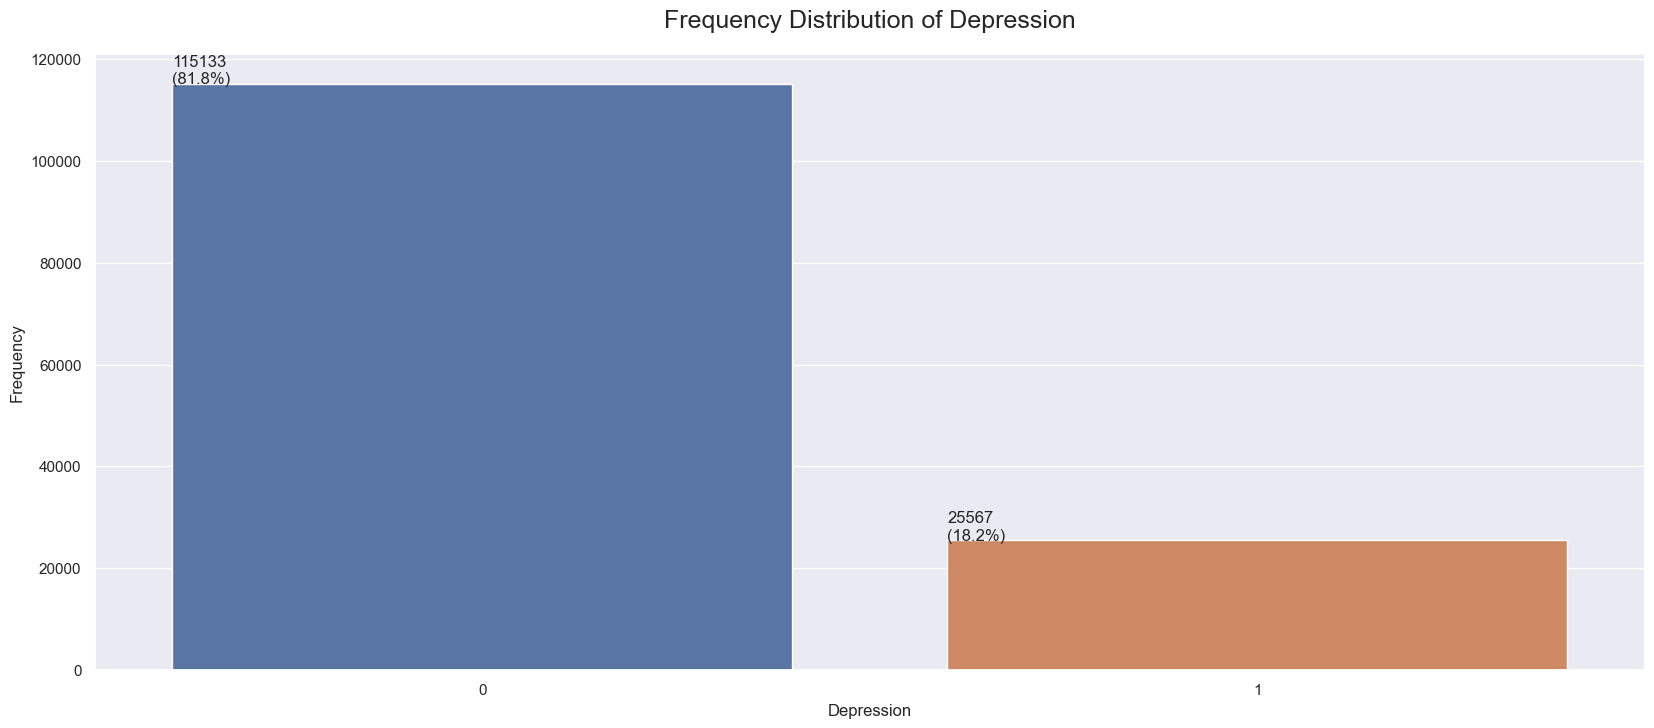

In [90]:
cat_dist(df=all_exp_datas,var_name='Depression',cat_limit=10)

# Training the Target_Flag data

In [91]:
# to get all object columns from our dataset
def obj_cols(df):
    '''
    This function returns the object columns in a given dataframe
    Parameters:
    	df (Pandas dataframe) : The dataframe in which to search for object columns

    Returns:
    	List of Object columns
    '''
    object_cols = df.select_dtypes(include = ['object']).columns
    if object_cols.shape[0]>0 :
        print('Count of object columns: {}'.format(object_cols.shape[0]))
        return list(object_cols.values)
    else:
        print('No object columns in the dataframe!')
        return

In [92]:
obj_cols(all_exp_datas)

No object columns in the dataframe!


In [93]:
#importing required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score
from sklearn.model_selection import cross_validate

In [94]:
#Seperating out the labels data
feature_cols = list(all_exp_datas.columns)
feature_cols.remove('Depression')

In [95]:
X = all_exp_datas.loc[:,feature_cols]
y = all_exp_datas['Depression']

In [96]:
#del all_exp_data['Depression']
all_exp_datas.head()

,Age,Work/Study Hours,Financial Stress,Depression
0,49,1,2,0
1,26,7,3,1
2,33,3,1,1
3,22,10,1,1
4,30,9,4,0


In [97]:
def viz_binary_class_distribution(data = None, var = None,x_labels=[0,1], title = 'Binomial Distribution' ):
    '''
    The function plots the distribution of a binomial variable with 0/1 labels
    PARAMETERS:
        data: Dataframe with the data to be plotted
        var : Column Name in the data passed as a string; Binomial labels (1/0) for which the distribution needs to be plotted
        x_labels : List of string labels for binomial classes in 0/1 order
        title :
    '''
    tot_count = data.shape[0]
    plt.figure(figsize=(8,6))
    sns.set_theme(style="darkgrid")
    ax = sns.countplot(x=var, data=data, order=[0,1])
    ax.set(xlabel = "Class", ylabel = 'Frequency')
    ax.set_xticklabels(x_labels)
    ax.set_title(title, y=1.03, fontsize=17)
    for p in ax.patches:
        ax.annotate('{}({:.1f}%))'.format(int(p.get_height()),p.get_height()/tot_count*100), (p.get_x()+0.2, p.get_height()+1))

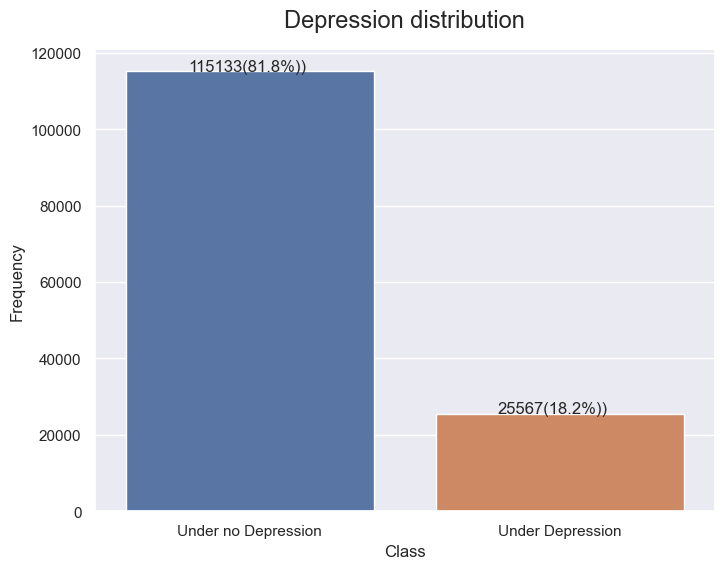

In [98]:
viz_binary_class_distribution(data = all_exp_datas, var = 'Depression' ,
                              x_labels=["Under no Depression", "Under Depression"],
                              title = 'Depression distribution' )

# Bivariate Analysis

In [99]:
#Function to show correlation matrix between all variables
def corr_matrix (df=None,method=None,show_values = True, return_flag = False):
    '''
    Function returns correlation of all variables with each other

    Parameters:
        df          : The dataframe with all variables
        method      : 'pearson','kendall','spearman'; Default is 'pearson'
        show_values : Boolean, Default True

    Returns:
        Correlation Matrix dataframe, if return_flag set to True. Returns nothing by default
    '''
    if method == None:
        method = 'pearson'
    corr_name = method+'corr'
    df_corr = df.corr(method)
    plt.figure(figsize = (12,10))
    if show_values == True: sns.heatmap(df_corr,cmap = 'coolwarm',annot=True)
    else: sns.heatmap(df_corr,cmap = 'coolwarm')

    if return_flag == True: return df_corr
    else : return

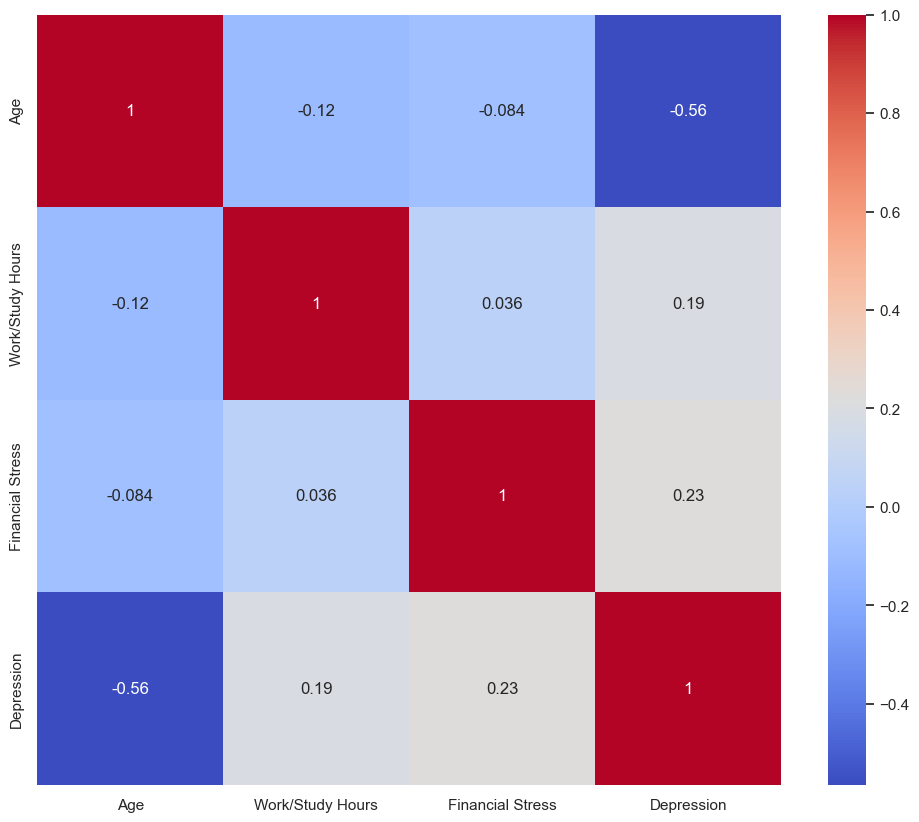

In [100]:
corr_matrix(df=all_exp_datas,show_values = True)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123,stratify = y)

In [102]:
X_train.head()

,Age,Work/Study Hours,Financial Stress
52171,22,10,4
89257,29,0,3
74558,38,7,4
35912,52,0,5
89152,58,3,5


In [103]:
y_train.head()

52171    1
89257    0
74558    0
35912    0
89152    0
Name: Depression, dtype: int64

In [104]:
X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112560 entries, 52171 to 7930
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Age               112560 non-null  int64
 1   Work/Study Hours  112560 non-null  int64
 2   Financial Stress  112560 non-null  int64
dtypes: int64(3)
memory usage: 3.4 MB
<class 'pandas.core.series.Series'>
Int64Index: 112560 entries, 52171 to 7930
Series name: Depression
Non-Null Count   Dtype
--------------   -----
112560 non-null  int64
dtypes: int64(1)
memory usage: 1.7 MB


In [105]:
#feature scaling
#Initializing an instance of the Std. Scaler Transformer
ss = StandardScaler()
#Scaling the train data and fitting the transform
X_train_scaled = ss.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled,columns=X.columns,index=X_train.index)
#Scaling the test data using the scaler function trained on the train data
X_test_scaled = ss.transform(X_test)
X_test = pd.DataFrame(X_test_scaled,columns=X.columns,index=X_test.index)

# Binary Classification Evaluation

In [106]:
#Binary Classification Evaluation Function:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, log_loss
def binary_classification_eval(y_true,y_pred,prob_thrs=0.5,return_conf_matrix = False,viz = True,):
    '''
    This function evaluates the performance of a classification model and returns evaluation metrics
    Reference: https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/
    Parameters:
        y_true (Numpy array) : The ground truth labels given in the dataset
        y_pred (Numpy array) : Model prediction probability
        prob_thrs (numeric)  : Between 0 and 1; 0.5 by default. Predicted values >= threshold are considered as positive and below are negative.
        viz                  : Returns Visualization on the classifier performance along with the metrics
        return_conf_matrix   : Returns the confusion matrix as a dataframe, Default is False

    Returns: Dataframe with below metrics to evaluate performance of the classification model
        1. Number of Observations : Rows on which the model is being evaluated, length of the y_pred/y_true series
            i.    Confusion Matrix
            ii.   Accuracy
            iii.  Precision : Ratio between the True Positives and all the Positives
            iv.   Recall : Measure of how accurately our model is able to identify the relevant data
            v.    F1 Score : Takes into account both Recall and Precision
            vi.   ROC AUC : Area under the Receiver Operating Characteristic Curve
            vii.  AUCPR : Area under the Precision-Recall Curve
        2. Log Loss / Binary Cross Entropy:
        3. Categorical Cross Entropy :

    '''
    if len(y_true) != len(y_pred):
        print('Length of Actual and Predicted lists is unequal. Please check and correct the same!')
        return

    n = len(y_true)
    #n_class = sum(np.ones(len(np.unique(y_true))))
    eval_metrics = dict()

    pred_df = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    pred_df['y_pred_r'] = np.vectorize(lambda x: 0 if (x < prob_thrs) else 1)(y_pred)
    cm = pd.crosstab(pred_df['y_pred_r'],pred_df['y_true'])
    cm.rename_axis('y_pred', inplace=True)
    normalized_cm=(cm-cm.min())/(cm.max()-cm.min())
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]

    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    auc_score = roc_auc_score(y_true, y_pred)
    fpr, tpr, t1 = roc_curve(y_true, y_pred)
    p, r, t2 = precision_recall_curve(y_true, y_pred)
    aucpr = auc(r, p)
    log_loss_ = log_loss(y_true, y_pred)

    eval_metrics['Length of Data'] = len(y_true)
    eval_metrics['True Positives'] = TP
    eval_metrics['True Negatives'] = TN
    eval_metrics['False Positives'] = FP
    eval_metrics['False Negatives'] = FN
    eval_metrics['Accuracy'] = accuracy
    eval_metrics['Precision'] = precision
    eval_metrics['Recall'] = recall
    eval_metrics['F1 Score'] = f1_score
    eval_metrics['AUR-ROC Score'] = auc_score
    eval_metrics['AUC-PR Score'] = aucpr
    eval_metrics['Log Loss / Binary Cross Entropy'] = log_loss_


    # Visualizations
    if viz == True:
        fig = plt.figure(figsize=(16,12))
        fig.suptitle('Classification Results')

        #Plotting confusion matrix
        ax1 = fig.add_subplot(2, 2, 1)
        ax1 = sns.heatmap(cm, annot=True, fmt='g', ax=ax1)
        # labels, title and ticks
        ax1.set_xlabel('True labels')
        ax1.set_ylabel('Predicted labels')
        ax1.set_title('Confusion Matrix')

        #Plotting the seperation between the predicted values
        ax2 = fig.add_subplot(2, 2, 2)
        ax2 = sns.kdeplot(pred_df[pred_df['y_true'] == 0]['y_pred'], fill = True, label = "0")
        ax2 = sns.kdeplot(pred_df[pred_df['y_true'] == 1]['y_pred'], fill = True, label = "1")
        ax2.set_title('Predictions KDE')
        ax2.set_xlabel('Predicted Probability')

        #Plotting the ROC-AUC Curve
        ax3 = fig.add_subplot(2, 2, 3)
        ax3 = sns.lineplot(x = fpr, y = tpr,ci=None)
        ax3.set_title('Receiver Operating Characteristic Curve')
        ax3.set_xlabel('FPR')
        ax3.set_ylabel('TPR')
        ax3.set_xlim([-0.05, 1.05])
        ax3.set_ylim([-0.05, 1.05])
        ax3.text(-0.02,1,'AUC score: {:0.3f}'.format(auc_score))

        #Plotting the Precision Recall Curve
        ax4 = fig.add_subplot(2, 2, 4)
        ax4 = sns.lineplot(x = r, y = p,ci=None)
        ax4.set_title('Precision-Recall Curve')
        ax4.set_xlabel('Recall')
        ax4.set_ylabel('Precision')
        ax4.set_xlim([-0.05, 1.05])
        ax4.set_ylim([-0.05, 1.05])
        ax4.text(-0.02,1,'AUCPR score: {:0.3f}'.format(aucpr))

        #fig.tight_layout()

    #Converting to Dataframe
    eval_metrics = pd.DataFrame([eval_metrics],columns=eval_metrics.keys()).T
    eval_metrics.columns = ['Value']
    eval_metrics.index.set_names('Evaluation Metric',inplace=True)
    eval_metrics['Value'] = eval_metrics['Value'].apply(lambda x: '%.2f' % x)

    if return_conf_matrix == False: return eval_metrics
    else: return eval_metrics, cm

# Model 1 - Random Forest

In [107]:
#feature scaling
#Initializing an instance of the Std. Scaler Transformer
ss = StandardScaler()
#Scaling the train data and fitting the transform
X_train_scaled = ss.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled,columns=X.columns,index=X_train.index)
#Scaling the test data using the scaler function trained on the train data
X_test_scaled = ss.transform(X_test)
X_test = pd.DataFrame(X_test_scaled,columns=X.columns,index=X_test.index)

In [108]:
#importing the required libraries
from sklearn.ensemble import RandomForestClassifier

In [109]:
# creating a RF classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
clf_rf = RandomForestClassifier(n_estimators = 100)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_rf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf_rf.predict(X_test)

In [110]:
y_pred[:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [111]:
test_output = pd.DataFrame({'y_true':y_test,'y_pred':y_pred})
test_output.head()

,y_true,y_pred
6772,0,0
41377,0,0
36802,0,0
16645,0,0
30349,0,1


C:\Users\Pramod\AppData\Local\Temp\ipykernel_10876\2269244710.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax3 = sns.lineplot(x = fpr, y = tpr,ci=None)
C:\Users\Pramod\AppData\Local\Temp\ipykernel_10876\2269244710.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax4 = sns.lineplot(x = r, y = p,ci=None)


,Value
Evaluation Metric,
Length of Data,28140.00
True Positives,3341.00
True Negatives,21601.00
False Positives,1426.00
False Negatives,1772.00
Accuracy,0.89
Precision,0.70
Recall,0.65
F1 Score,0.68


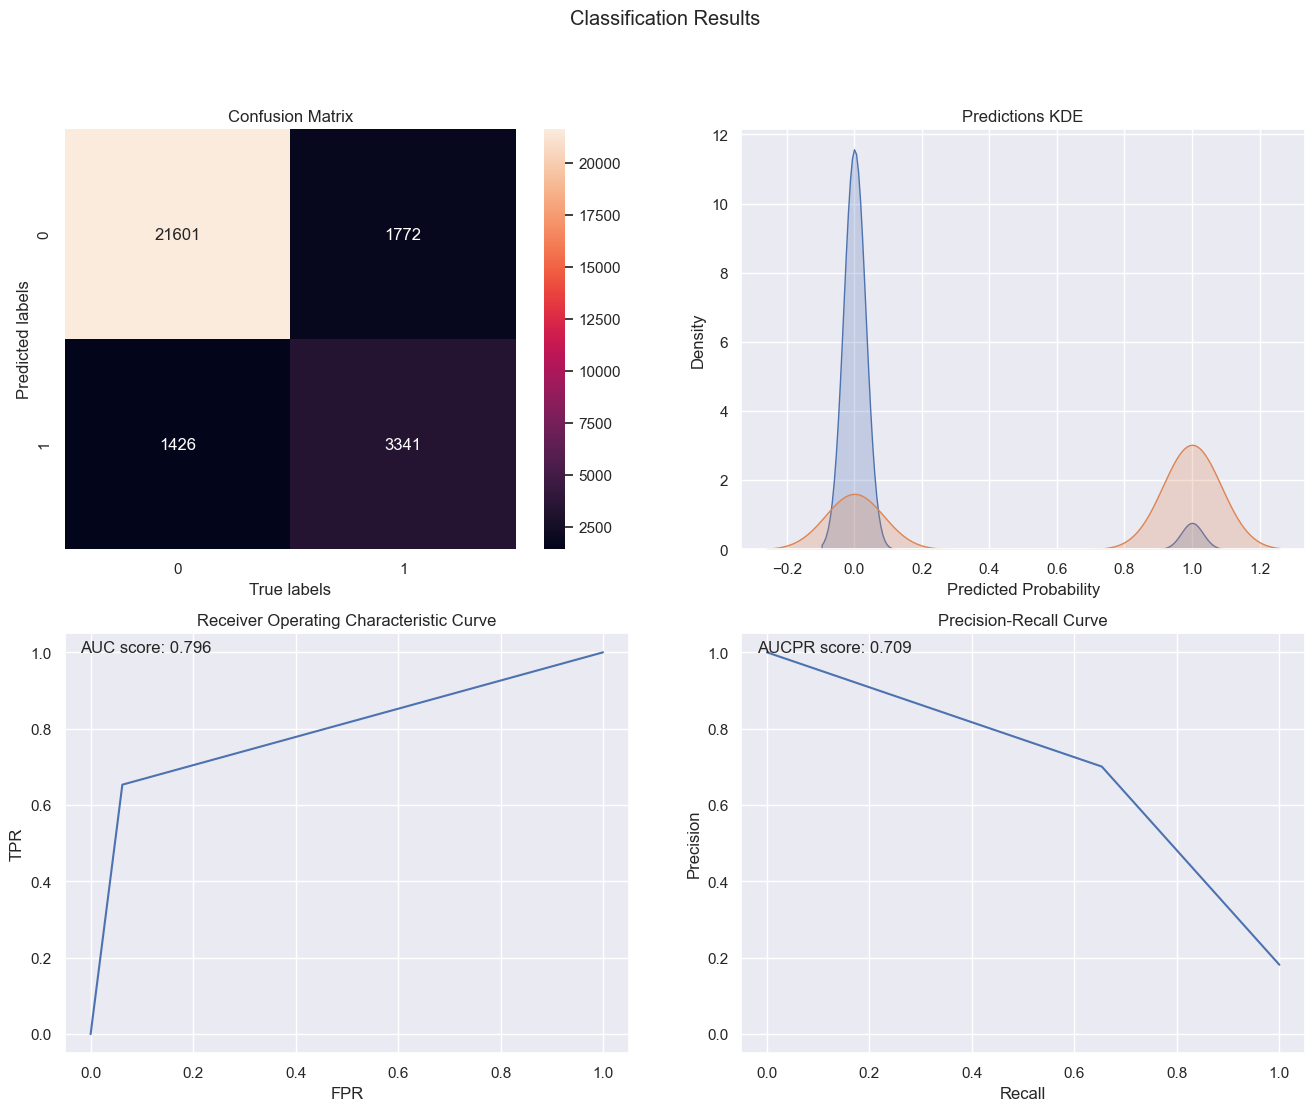

In [112]:
binary_classification_eval(test_output['y_true'],test_output['y_pred'],
                           prob_thrs=0.5,return_conf_matrix = False,viz = True)

# Model 2 Logistic Regression

In [113]:
from sklearn.linear_model import LogisticRegression

In [114]:
# Initializing an instance of the Legistic Regression model
lr_model = LogisticRegression(max_iter = 1000)
# Fitting the model to the train data
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [115]:
# Calculating the probablilites using logistic regression
test_pred=lr_model.predict_proba(X_test)
train_pred=lr_model.predict_proba(X_train)

In [116]:
#Let's see the results of the predict_proba function
test_pred[0:5]

array([[0.91912511, 0.08087489],
       [0.97202522, 0.02797478],
       [0.9763968 , 0.0236032 ],
       [0.95696284, 0.04303716],
       [0.26134518, 0.73865482]])

In [117]:
#The results above are the probability of the answer being either of the classes 1/0(worn/unworn)
lr_model.classes_

array([0, 1], dtype=int64)

In [118]:
# Since we have encoded worn as 1, we would like to see the probability of 1,
# so let's find the position of Class `1`
list(lr_model.classes_).index(1)

1

In [119]:
#Using this index let's get the probabilities in an array
test_pred1 = []
for val in test_pred:
    test_pred1.append(val[list(lr_model.classes_).index(1)])

In [120]:
test_output = pd.DataFrame({'y_true':y_test,'y_pred':test_pred1})
test_output.head()

,y_true,y_pred
6772,0,0.080875
41377,0,0.027975
36802,0,0.023603
16645,0,0.043037
30349,0,0.738655


C:\Users\Pramod\AppData\Local\Temp\ipykernel_10876\2269244710.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax3 = sns.lineplot(x = fpr, y = tpr,ci=None)
C:\Users\Pramod\AppData\Local\Temp\ipykernel_10876\2269244710.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax4 = sns.lineplot(x = r, y = p,ci=None)


,Value
Evaluation Metric,
Length of Data,28140.00
True Positives,3138.00
True Negatives,21704.00
False Positives,1323.00
False Negatives,1975.00
Accuracy,0.88
Precision,0.70
Recall,0.61
F1 Score,0.66


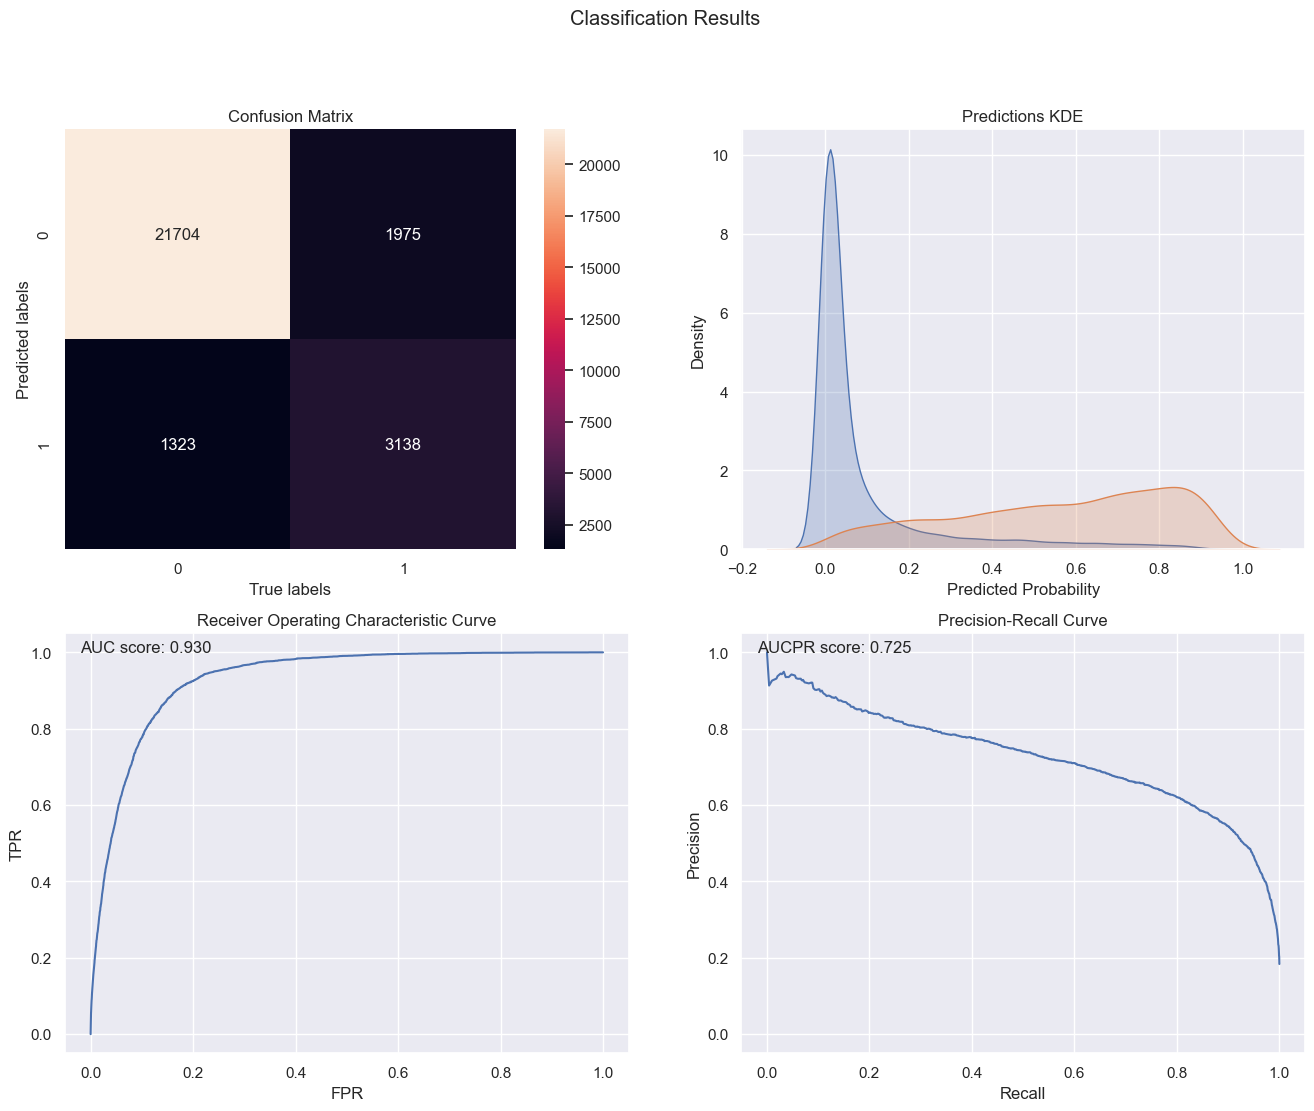

In [121]:
binary_classification_eval(test_output['y_true'],test_output['y_pred'],
                           prob_thrs=0.5,return_conf_matrix = False,viz = True)

#KDE - KERNEL DENSITY ESTIMATE PLOT

# Model 3 Decision Tree

In [122]:
#importing the required libraries
from sklearn.tree import DecisionTreeClassifier

In [123]:
# creating a DT classifier
# https://scikit-learn.org/stable/modules/tree.html
clf_dt = DecisionTreeClassifier(random_state=0, max_depth=4)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_dt.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf_dt.predict(X_test)

In [124]:
# #Installing these additional modules if necessary
!pip install graphviz
!pip install pydotplus

In [125]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf_dt, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('decisionTree_Viz.png')
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [ ]:
test_output = pd.DataFrame({'y_true':y_test,'y_pred':y_pred})
test_output.head()

In [ ]:
binary_classification_eval(test_output['y_true'],test_output['y_pred'],
                           prob_thrs=0.5,return_conf_matrix = False,viz = True)